Using Galerkin Spectral method to find numerical solution to Poisson equation with RHS sin(pi*x)

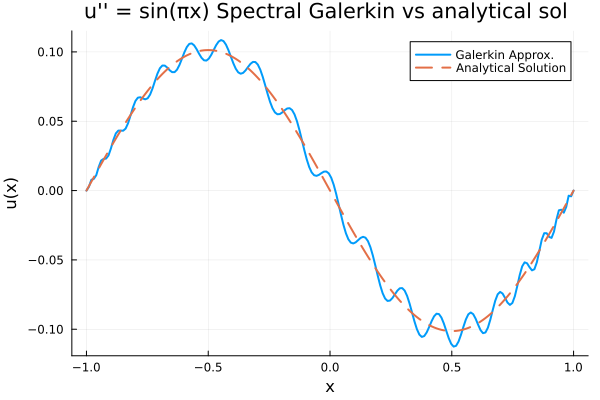

In [49]:
using LinearAlgebra
using Plots

N = 41
x = cos.(π * (0:N) / N) # Nodes

# Chebyshev-T polynomial, T_k(x)
function T(k, x)
    return cos.(k * acos.(x))
end

# RHS of poisson eqn e.g.
f(x) = sin(π*x)

# Modified basis function so that boundary conds are satisfied
function phi_mod(k,x)
    return (1 .- x.^2) .* T(k, x)
end

# Second derivative via central differences
function second_derivative(y, x)
    n = length(x)
    d2y = zeros(n)
    for i in 2:n-1
        h1 = x[i] - x[i-1]
        h2 = x[i+1] - x[i]
        d2y[i] = 2 * ((y[i+1] - y[i]) / h2 - (y[i] - y[i-1]) / h1) / (h1 + h2)
    end

    d2y[1] = d2y[2]
    d2y[end] = d2y[end-1]

    return d2y
end

# Assemble linear system Av=b
A = zeros(N+1, N+1)
b = zeros(N+1)

ϕ = [phi_mod(k, x) for k in 0:N]  # modified phi evaluated at the nodes

for j in 1:N+1
    b[j] = dot([f(a) for a in x], ϕ[j])  # Inner product

    # Within j loop start k loop for matrix A
    for k in 1:N+1
        d2ϕ_k = second_derivative(ϕ[k], x)
        A[j, k] = dot(d2ϕ_k, ϕ[j])         # Galerkin matrix entry
    end
end

v = A \ b

# Construct approximate solution on a dense grid
x_dense = LinRange(-1, 1, 200)
ϕ_dense = [(1 .- x_dense.^2) .* T(k, x_dense) for k in 0:N]
u_approx = reduce(+, (v[k+1] .* ϕ_dense[k+1] for k in 0:N))
u_true = -sin.(π .* x_dense) ./ π^2

# Plots
plot(x_dense, u_approx, label="Galerkin Approx.", lw=2, grid=true)
plot!(x_dense, u_true, label="Analytical Solution", lw=2, ls=:dash)
title!("u'' = sin(πx) Spectral Galerkin vs analytical sol ")
xlabel!("x")
ylabel!("u(x)")

# I get weird oscillations when setting N=40 or 41 for some reason I do not understand


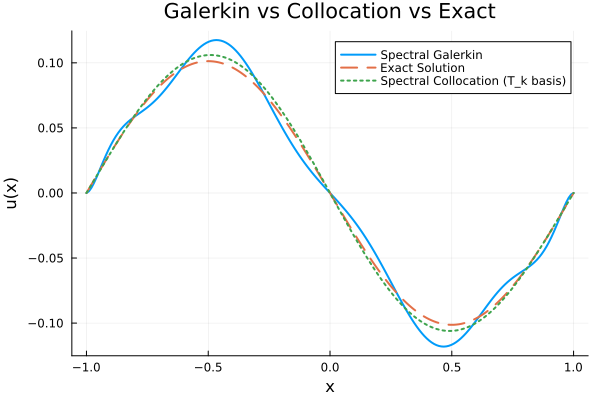

In [13]:
using LinearAlgebra
using Plots

# -------------------------------
# 1. PRELIMINARIES: Chebyshev nodes & polynomials
# -------------------------------

N = 10
x = cos.(π * (0:N) ./ N)   # Chebyshev–Lobatto nodes (length N+1): x[1]=+1, x[N+1]=−1

# Chebyshev–T polynomial of degree k, evaluated on a vector x_vals
function T(k, x_vals::AbstractVector)
    return cos.(k .* acos.(x_vals))
end

# Right‐hand‐side function for Poisson equation: u'' = sin(π x)
f(x_vals) = sin.(π .* x_vals)

# Second derivative via nonuniform central differences
function second_derivative(y_vals::AbstractVector, x_vals::AbstractVector)
    n = length(x_vals)
    d2 = zeros(n)
    for i in 2:n-1
        h1 = x_vals[i] - x_vals[i-1]
        h2 = x_vals[i+1] - x_vals[i]
        d2[i] = 2 * ((y_vals[i+1] - y_vals[i]) / h2 - (y_vals[i] - y_vals[i-1]) / h1) / (h1 + h2)
    end
    # For endpoints, just copy the nearest interior value
    d2[1]   = d2[2]
    d2[end] = d2[end-1]
    return d2
end

# -------------------------------
# 2. SPECTRAL GALERKIN PART
# -------------------------------

# We solve ∫ (−u''(x) − f(x)) * φ_j(x) dx = 0
# with basis φ_k(x) = (1−x^2)*T_k(x), automatically satisfying φ_k(±1)=0.

# Build Galerkin matrix A_g and right‐hand side b_g
A_g = zeros(N+1, N+1)
b_g = zeros(N+1)

# Precompute φ_k(x) at all nodes x
# φ_all[k+1] is φ_k(x) vector over the Chebyshev nodes
phi_all = [ (1 .- x.^2) .* T(k, x) for k in 0:N ]

for j in 1:N+1
    # RHS j: inner product ⟨f, φ_j⟩ ≈ dot(f(x), φ_j(x))
    b_g[j] = dot(f(x), phi_all[j])

    for k in 1:N+1
        # Compute φ_k''(x) via central differences, then inner product with φ_j
        d2phi_k = second_derivative(phi_all[k], x)
        A_g[j, k] = dot(d2phi_k, phi_all[j])
    end
end

# Solve Galerkin linear system for coefficients v_g
v_g = A_g \ b_g

# Evaluate Galerkin solution on a fine grid for plotting
x_dense = LinRange(-1, 1, 200)
phi_dense = [ (1 .- x_dense.^2) .* T(k, x_dense) for k in 0:N ]
u_gal = zeros(length(x_dense))
for k in 0:N
    u_gal .+= v_g[k+1] .* phi_dense[k+1]
end

# Exact solution for comparison: u_exact(x) = −sin(π x)/π^2, satisfying u(±1)=0
u_exact = -sin.(π .* x_dense) ./ π^2

# Plot Spectral Galerkin vs. Exact
plt = plot(
    x_dense, u_gal,
    label="Spectral Galerkin",
    lw=2, grid=true
)
plot!(
    x_dense, u_exact,
    label="Exact Solution",
    lw=2, ls=:dash
)
title!(plt, "Spectral Galerkin vs Exact")
xlabel!(plt, "x")
ylabel!(plt, "u(x)")

# -------------------------------
# 3. SPECTRAL COLLOCATION PART (original T_k basis)
# -------------------------------

# *** NEW CODE STARTS HERE ***

# We now approximate u(x) ≈ Σ_{k=0..N} v_k * T_k(x),
# and enforce:
#   1) u(−1) = 0  (at node x[N+1] if x[1]=+1, x[N+1]=−1 ordering is swapped)
#   2) u(+1) = 0  (at node x[1])
#   3) For j=2..N, u''(x[j]) = f(x[j])  (interior Chebyshev–Lobatto nodes)

# Recompute T_k(x) on these reordered nodes
T_all = [ T(k, x) for k in 0:N ]  # list of length N+1, each is length N+1

# Build collocation matrix A_c (size (N+1)×(N+1)) and RHS b_c
A_c = zeros(N+1, N+1)
b_c = zeros(N+1)

for j in 1:N+1
    if j == 1
        # Enforce u(−1) = Σ_{k=0..N} v_k * T_k(x[1]) = 0
        for k in 0:N
            A_c[1, k+1] = T_all[k+1][1]   # T_k at x[1]
        end
        b_c[1] = 0.0
    elseif j == N+1
        # Enforce u(+1) = Σ_{k=0..N} v_k * T_k(x[N+1]) = 0
        for k in 0:N
            A_c[N+1, k+1] = T_all[k+1][N+1]  # T_k at x[N+1]
        end
        b_c[N+1] = 0.0
    else
        # For interior j=2..N, enforce u''(x[j]) = f(x[j])
        # Compute second derivative of each T_k at all nodes
        for k in 0:N
            d2T_k = second_derivative(T_all[k+1], x)  
            A_c[j, k+1] = d2T_k[j]
        end
        b_c[j] = f(x[j])
    end
end

# Solve the collocation system for v_c (length N+1)
v_c = A_c \ b_c

# Evaluate collocation solution on dense grid
u_col = zeros(length(x_dense))
for k in 0:N
    u_col .+= v_c[k+1] .* T(k, x_dense)
end

# Plot Collocation solution alongside previous curves
plot!(
    x_dense, u_col,
    label="Spectral Collocation (T_k basis)",
    lw=2, ls=:dot
)
title!(plt, "Galerkin vs Collocation vs Exact")
# *** END OF NEW CODE ***

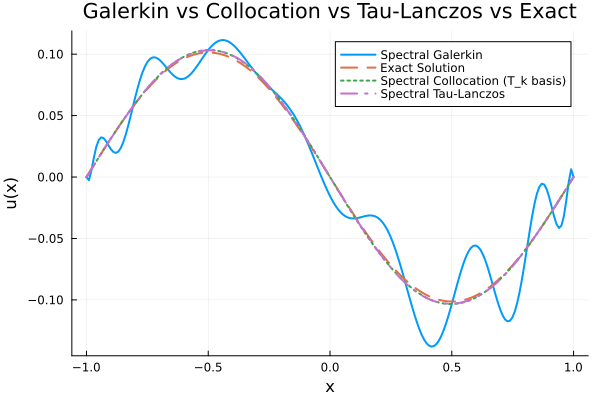

In [20]:
using LinearAlgebra
using Plots

# -------------------------------
# 1. PRELIMINARIES: Chebyshev nodes & polynomials
# -------------------------------

N = 15
x = cos.(π * (0:N) ./ N)   # Chebyshev–Lobatto nodes: x[1]=+1, x[N+1]=−1

# Chebyshev–T polynomial of degree k, evaluated on a vector x_vals
function T(k, x_vals::AbstractVector)
    return cos.(k .* acos.(x_vals))
end

# Right‐hand‐side for Poisson: u'' = sin(π x)
f(x_vals) = sin.(π .* x_vals)

# Second derivative via nonuniform central differences
function second_derivative(y_vals::AbstractVector, x_vals::AbstractVector)
    n = length(x_vals)
    d2 = zeros(n)
    for i in 2:n-1
        h1 = x_vals[i]   - x_vals[i-1]
        h2 = x_vals[i+1] - x_vals[i]
        d2[i] = 2 * ((y_vals[i+1] - y_vals[i]) / h2 - (y_vals[i] - y_vals[i-1]) / h1) / (h1 + h2)
    end
    # For endpoints, copy the nearest interior approximation
    d2[1]   = d2[2]
    d2[end] = d2[end-1]
    return d2
end

# -------------------------------
# 2. SPECTRAL GALERKIN PART
# -------------------------------

# Basis φ_k(x) = (1−x^2)*T_k(x) enforces φ_k(±1)=0
A_g = zeros(N+1, N+1)
b_g = zeros(N+1)

# Precompute φ_k(x) for k=0..N at the Chebyshev nodes
phi_all = [ (1 .- x.^2) .* T(k, x) for k in 0:N ]

for j in 1:N+1
    # b_g[j] = ⟨f, φ_j⟩ ≈ dot(f(x), φ_j(x))
    b_g[j] = dot(f(x), phi_all[j])
    for k in 1:N+1
        # A_g[j,k] = ⟨φ_k''(x), φ_j(x)⟩ ≈ dot(φ_k''(x), φ_j(x))
        d2phi_k = second_derivative(phi_all[k], x)
        A_g[j, k] = dot(d2phi_k, phi_all[j])
    end
end

# Solve for Galerkin coefficients v_g
v_g = A_g \ b_g

# Evaluate Galerkin solution on a fine grid
x_dense = LinRange(-1, 1, 200)
phi_dense = [ (1 .- x_dense.^2) .* T(k, x_dense) for k in 0:N ]
u_gal = zeros(length(x_dense))
for k in 0:N
    u_gal .+= v_g[k+1] .* phi_dense[k+1]
end

# Exact solution: u_exact(x) = −sin(π x)/π^2 (satisfies u(±1)=0)
u_exact = -sin.(π .* x_dense) ./ π^2

# Plot Galerkin vs Exact
plt = plot(
    x_dense, u_gal,
    label="Spectral Galerkin",
    lw=2, grid=true
)
plot!(
    x_dense, u_exact,
    label="Exact Solution",
    lw=2, ls=:dash
)
title!(plt, "Spectral Galerkin vs Exact")
xlabel!(plt, "x")
ylabel!(plt, "u(x)")

# -------------------------------
# 3. SPECTRAL COLLOCATION PART (original T_k basis)
# -------------------------------

# Precompute T_k(x) at the Chebyshev nodes for k=0..N
T_all = [ T(k, x) for k in 0:N ]  # each is length N+1

# Build collocation matrix A_c (size (N+1)×(N+1)) and RHS b_c
A_c = zeros(N+1, N+1)
b_c = zeros(N+1)

for j in 1:N+1
    if j == 1
        # x[1] = +1  ⇒  enforce u(+1) = Σ v_k T_k(+1) = 0
        for k in 0:N
            A_c[1, k+1] = T_all[k+1][1]   # T_k(+1)
        end
        b_c[1] = 0.0

    elseif j == N+1
        # x[N+1] = −1  ⇒  enforce u(−1) = Σ v_k T_k(−1) = 0
        for k in 0:N
            A_c[N+1, k+1] = T_all[k+1][N+1]  # T_k(−1)
        end
        b_c[N+1] = 0.0

    else
        # interior node x[j]: enforce u''(x[j]) = f(x[j])
        for k in 0:N
            d2T_k = second_derivative(T_all[k+1], x)
            A_c[j, k+1] = d2T_k[j]
        end
        b_c[j] = f(x[j])
    end
end

# Solve collocation for v_c
v_c = A_c \ b_c

# Evaluate collocation solution on dense grid
u_col = zeros(length(x_dense))
for k in 0:N
    u_col .+= v_c[k+1] .* T(k, x_dense)
end

# Plot Collocation
plot!(
    x_dense, u_col,
    label="Spectral Collocation (T_k basis)",
    lw=2, ls=:dot
)
title!(plt, "Galerkin vs Collocation vs Exact")

# -------------------------------
# 4. SPECTRAL TAU-LANCZOS METHOD
# -------------------------------

# (a) Chebyshev–Lobatto quadrature weights w_j on [-1,1]
w = zeros(N+1)
for j in 1:N+1
    w[j] = (j == 1 || j == N+1) ? π/(2N) : π/N
end

# (b) Build Tmat and D2Tmat:
#     Tmat[j,k]   = T_{k-1}(x[j]),  j=1..N+1, k=1..N+1
#     D2Tmat[j,k] = T_{k-1}''(x[j]) via second_derivative
Tmat  = [ T(k-1, x[j]) for j in 1:N+1, k in 1:N+1 ]
D2Tmat = zeros(N+1, N+1)
for k in 0:N
    d2Tk = second_derivative(T_all[k+1], x)
    D2Tmat[:, k+1] = d2Tk
end

# (c) Build Tau‐Lanczos system A_tau * v = b_tau
A_tau = zeros(N+1, N+1)
b_tau = zeros(N+1)

# Enforce ⟨u'' - f, T_i⟩ = 0 for i = 0..N-2  ⇒ i=1..N-1 in 1-based
for i in 1:N-1
    for k in 0:N
        A_tau[i, k+1] = sum( w[j] * D2Tmat[j, k+1] * T(i-1, x[j]) for j in 1:N+1 )
    end
    b_tau[i] = sum( w[j] * f(x[j]) * T(i-1, x[j]) for j in 1:N+1 )
end

# Last two rows: enforce u(-1) = 0 and u(+1) = 0
for k in 0:N
    A_tau[N,   k+1] = Tmat[N+1, k+1]   # T_k(-1)
    A_tau[N+1, k+1] = Tmat[1,    k+1]   # T_k(+1)
end
b_tau[N]   = 0.0
b_tau[N+1] = 0.0

# (d) Solve for Tau-Lanczos coefficients v_tau
v_tau = A_tau \ b_tau

# (e) Evaluate Tau-Lanczos solution on dense grid
u_tau = zeros(length(x_dense))
for k in 0:N
    u_tau .+= v_tau[k+1] .* T(k, x_dense)
end

# Plot Tau-Lanczos
plot!(
    x_dense, u_tau,
    label="Spectral Tau-Lanczos",
    lw=2, ls=:dashdot
)

title!(plt, "Galerkin vs Collocation vs Tau-Lanczos vs Exact")

NEW Galerkin, trying to get sol to poisson eqn accurate to 10^-16

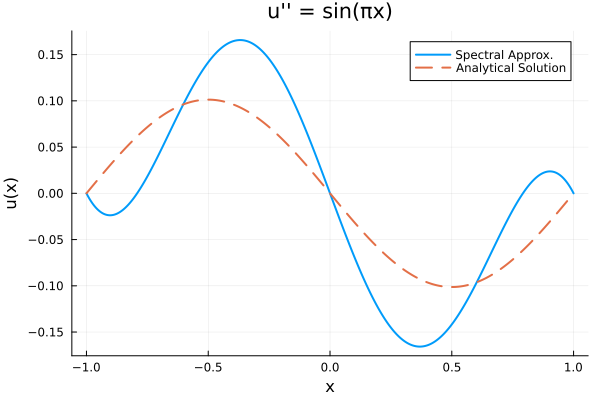

In [59]:
using ClassicalOrthogonalPolynomials, Plots
f(x) = sin(π*x)
Tbasis = ChebyshevT()  # Chebyshev basis
Cbasis = Ultraspherical(2)  # Ultraspherical basis for calculating 2nd derivative

x = axes(Tbasis,1)  # quasi-vector
D_2 = Cbasis \ diff(Tbasis,2)  # Finds second derivative and converts basis from Chebyshev to Ultraspherical

L = D_2
rhs = transform(Tbasis, f)  # Transforms RHS to Chebyshev coefficients

# Solve PDE Lu = f, BCs: u(-1) = u(1) = 0
A = [Tbasis[[-1, 1], :]; L]
b = [0; 0; rhs]
u_coeffs = A \ b

u_approx = (Tbasis * u_coeffs)
x_plot = range(-1, 1, 1000)
# Analytical solution
u_true = -sin.(π .* x_plot) ./ π^2

# Plot
plot(u_approx, label="Spectral Approx.", lw=2, grid=true)
plot!(x_plot, u_true, label="Analytical Solution", lw=2, ls=:dash)
title!("u'' = sin(πx)")
xlabel!("x")
ylabel!("u(x)")

# NOT ACCURATE

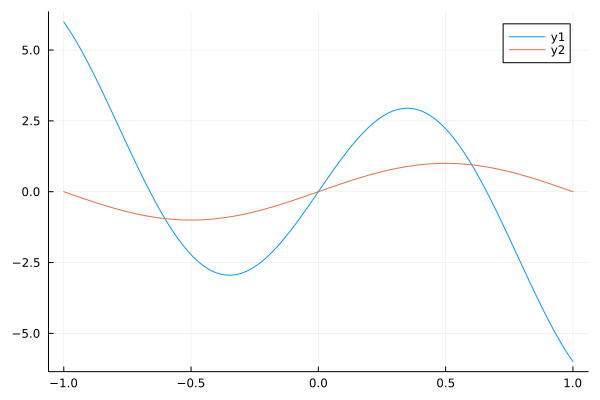

In [60]:
plot(diff(diff(u_approx)))
plot!(x_plot, sin.(π.*x_plot))

Can't get code to work accurately for the poisson problem but we move on to applying the spectral method to find the green's function for the PDE Olver gave us